This notebook looks into using various python based machine leaning and data science libraries in an attempt to build a machine learning model capable of predicting fraudulent transactions for a financial company.

We're going to take the following approach:
1. Problem defination
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

### 1. Problem Defination

In a statement,
> Give financial data about the company, can we predict fraudulent transactions for a financial company and develop an actionable plan?

### 2. Data

> Data for the case is available in CSV format having 6362620 rows and 10 columns which you can access through the drive link :
https://drive.google.com/uc?export=download&confirm=6gh6&id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV

### 3. Evaluation

> We will evaluate our project on the fact that iff we can reach 95% accuracy at predicting whether or not a transaction made is a fraudulent one during the proof of concept.

### 4. Features

> **Create a data dictionary**
    
    * step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

    * type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

    * amount - amount of the transaction in local currency.

    * nameOrig - customer who started the transaction

    * oldbalanceOrg - initial balance before the transaction

    * newbalanceOrig - new balance after the transaction

    * nameDest - customer who is the recipient of the transaction

    * oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

    * newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

    * isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

    * isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [52]:
# Importing all the tools needed

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [5]:
# Load data
df = pd.read_csv("/kaggle/input/fraudulent-transactions-data/Fraud.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [6]:
df.shape

(6362620, 11)

## Data Exploration (Exploratory Data Analysis or EDA)

The goal here is toh find more about the dataset and become a subject matter expert on the dataset we are working with.

1. What question(s) are we trying to solve (or prove wrong)?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do we deal with it?
4. Where are the outliers and why should we care about them?
5. How can we add, change or remove features to get more out of our data?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
df.duplicated().sum()

0

* There are no missing nor duplicate values. 
* The dtype of `type`, `nameOrig`, `nameDest` is object, we will convert them in numeric form.
* `isFraud` is the target column, whereas `isFlaggedFraud` is a feature column
* When we look at the dataset `nameOrig`, `nameDest` don't serve much purpose in the analysis of the data so we will remove it.

In [11]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [13]:
pd.crosstab(df.isFraud, df.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


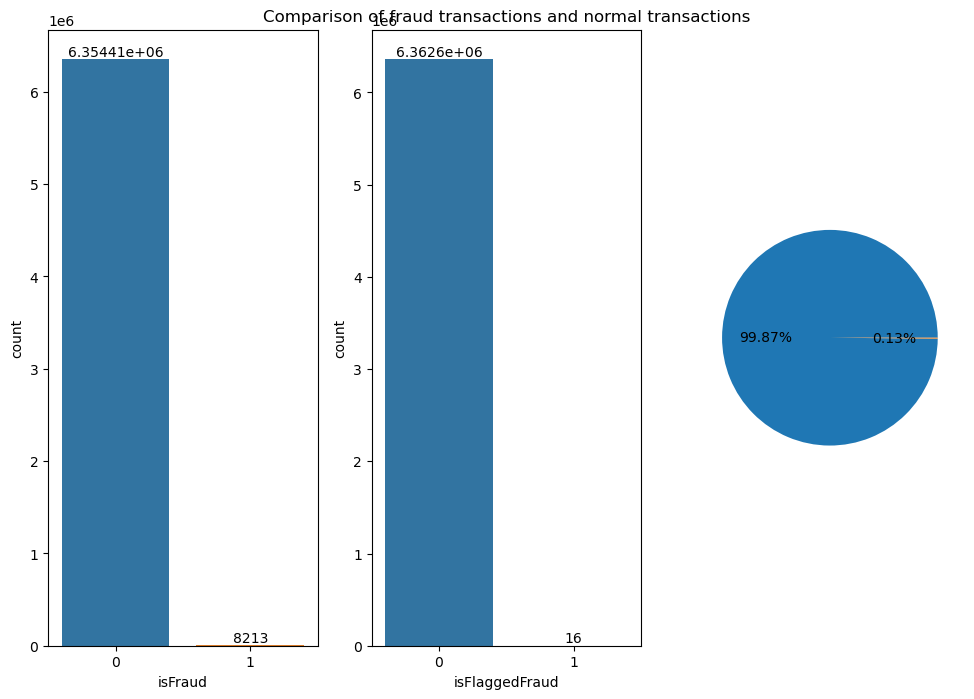

In [14]:
# Let's visualize this

ax, figure = plt.subplots(figsize = (16, 8))

plt.subplot(141)
ax = sns.countplot(x=df['isFraud'])
ax.bar_label(ax.containers[0])

plt.subplot(142)
ax = sns.countplot(x=df['isFlaggedFraud'])
ax.bar_label(ax.containers[0])

plt.subplot(143)
plt.pie(df['isFraud'].value_counts(),  autopct='%.2f%%')

ax.set_title("Comparison of fraud transactions and normal transactions", loc = "center")
plt.show()

The data is disproportionate as we have normal transactions more than fraud transactions. It becomes difficult to train a model with such less data. 

In [15]:
df[df['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


All the positive `isFlaggedFraud` transactions are single transactions of more than 200.000.

In [16]:
# Let's check the payment method count 
df["type"].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [17]:
pd.crosstab(df.type, df.isFraud)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


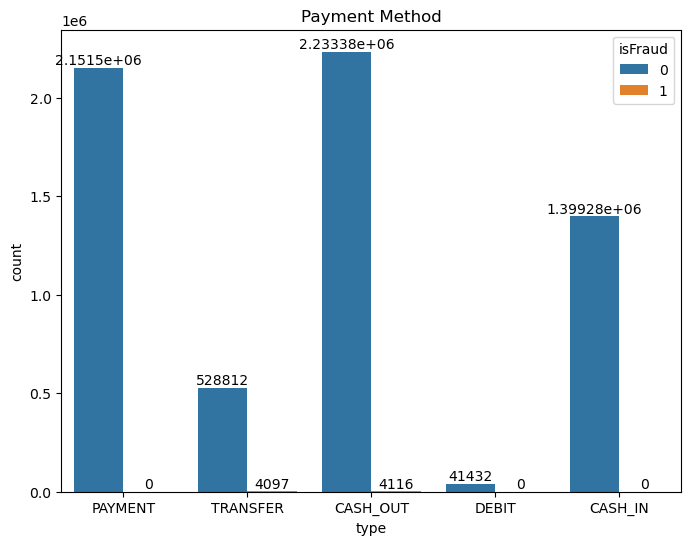

In [18]:
# Let's see which type of payment method is most used for fradulent transactions

ax, figure = plt.subplots(figsize = (8, 6))

ax = sns.countplot(data=df, x=df['type'], hue='isFraud')
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])

plt.title('Payment Method')
plt.show()

We can only see frauds in `transfer` and `cash out` type methods.

In [19]:
df.amount.max()

92445516.64

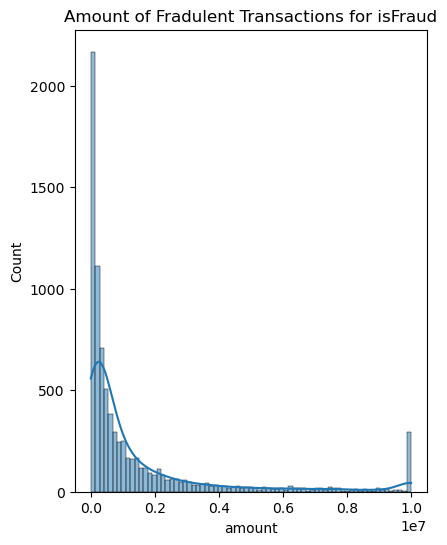

In [20]:
ax, figure = plt.subplots(figsize = (10, 6))

plt.subplot(121)
ax = sns.histplot(data=df[df['isFraud']==1],x='amount', kde=True)
plt.title('Amount of Fradulent Transactions for isFraud')

plt.show()

As we can see, most of the fraud transactions are mostly below 200000

In [21]:
# Let's see the Correlation Matrix
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


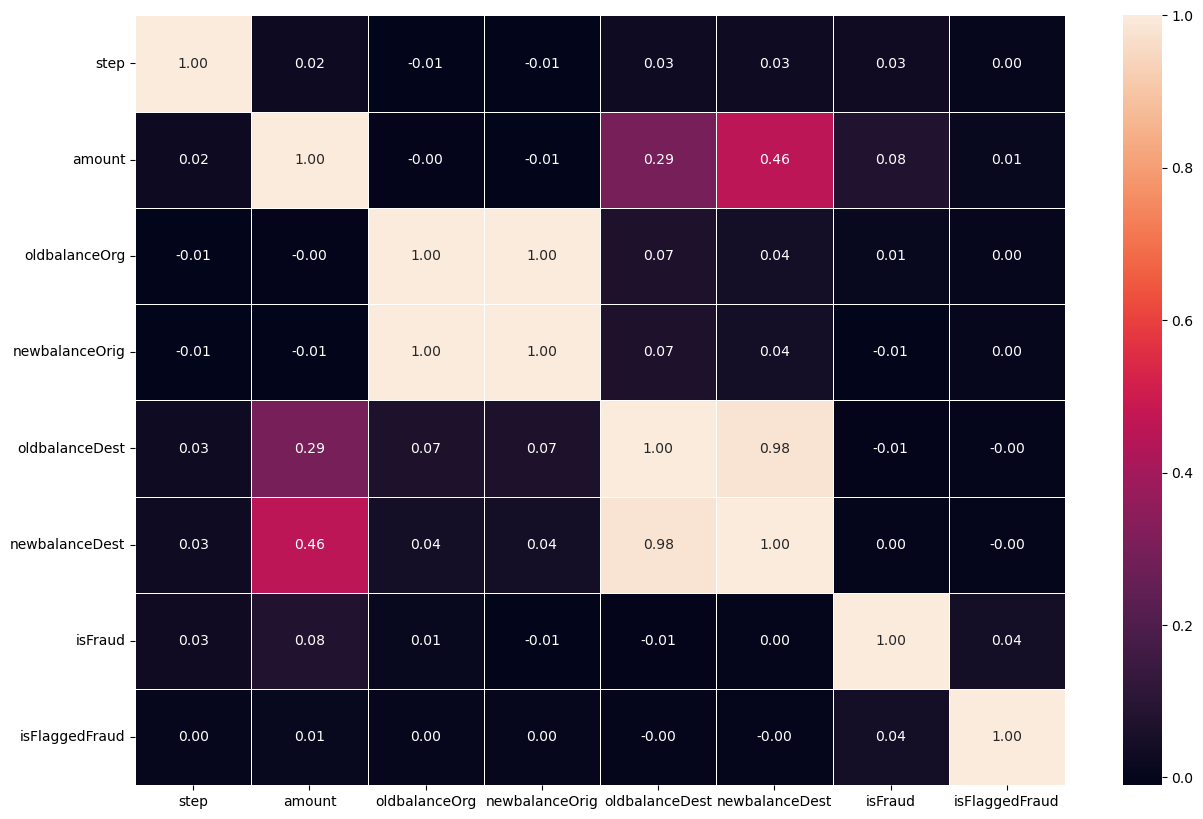

In [22]:
# Let's make our correlation matrix more visual
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix, 
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f");

The correlation between the features are normal. None of the features are highly correlated to each other except the `newbalanceDest` and the `oldbalanceDest`, which is bound to happend.

In [23]:
# Let's make a duplicated of the original data and remove nameOrig, nameDest

df_old = df.copy()
df_old

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [24]:
df.drop(['nameOrig', 'nameDest'], axis = 1, inplace = True)
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [25]:
# Let's change the dtype of Payment type

le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,3,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,4,181.00,181.00,0.00,0.00,0.00,1,0
3,1,1,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,3,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,4,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,1,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,4,850002.52,850002.52,0.00,0.00,0.00,1,0


## 5. Modelling

In [26]:
# Splitting features and target data into x and y 

x = df.drop("isFraud", axis = 1)
y = df["isFraud"]

# Set random seed
np.random.seed(42)

# Split data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3)

Now we've got our data into training and validation sets. Let's build a model.

We are going to train our data in these models:

1. Random Forest Classifier
2. Logistic Regression
3. KNeighbors Classifier
4. GaussianNB
5. DecisionTree Classifier
6. XGBClassifier

In [27]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

# tranform value for valid data
x_valid = scaler.transform(x_valid)

In [28]:
models = {"Random Forest Classifier" : RandomForestClassifier(),
          "Logistic Regression" : LogisticRegression(max_iter = 200),
          "KNeighbors Classifier" : KNeighborsClassifier(),
          "GaussianNB" : GaussianNB(),
          "XGB Classifier" : XGBClassifier()}

In [29]:
def fit_and_score (models, x_train, x_valid, y_train, y_valid):
    """
    Fits and evaluates the given models.
    """
    
    # Set random seed
    np.random.seed(42)
    
    # Set empty dictionary
    model_scores = {}
    
    # Loop through models
    for names, model in models.items():
        
        # Fit the model
        model.fit(x_train, y_train)
    
        
        # Evaluate the model and append the score to model_scores
        model_scores[names] = model.score(x_valid, y_valid)
        
    return model_scores

In [30]:
model_score = fit_and_score(models = models,
                             x_train = x_train,
                             x_valid = x_valid,
                             y_train = y_train,
                             y_valid = y_valid)
model_score

{'Random Forest Classifier': 0.9996971897321124,
 'Logistic Regression': 0.9988034279379668,
 'KNeighbors Classifier': 0.9994609139002486,
 'GaussianNB': 0.9952414780913104,
 'XGB Classifier': 0.999803016157914}

In [31]:
model_table = pd.DataFrame(model_score, index = ["Scores"])
model_table.T

,Scores
Random Forest Classifier,0.999697
Logistic Regression,0.998803
KNeighbors Classifier,0.999461
GaussianNB,0.995241
XGB Classifier,0.999803


After scoring our model, we can see that all our models seems to overfitting with a 99% accuracy. This is not a good thing for us and it's is due to lack of data. Therefore, we need more data to train our models to get an realistic and ideal score and then test it. But for now we are going to use one of the models to predict on out test data and evaluate it. We will use GaussianNB on our test data.

We will tune the hyperparameters of our model (we do this to particulary increase the performance of our model)

## 6. Experimentation

In [38]:
# Create a hyperparameter grid for GaussianNB()
gs_NB_grid = {"var_smoothing" : np.logspace(0,-9, num=100)}

# Let's try RandomizedSearchCV on GaussianNB
rs_NB_gs = RandomizedSearchCV(C, 
                 param_distributions = gs_NB_grid, 
                 cv = 5,
                 verbose=1,
                 n_iter = 20,
                 random_state = 42)
rs_NB_gs.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=20,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.5111917...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=42, verbose=1)

In [39]:
ideal_model =  rs_NB_gs.predict(x_valid)
def evaluate_preds (y_valid, y_preds):
    """
    Performs evaluation comparison on y_test labels and y_preds labels on our classification model.
    """
    accuracy = accuracy_score(y_valid, y_preds)
    precision = precision_score(y_valid, y_preds)
    recall = recall_score(y_valid, y_preds)
    f1 = f1_score(y_valid, y_preds)
    
    metric_dict = {"accuracy" : round(accuracy, 2),
                   "precision" : round(precision, 2),
                   "recall" : round(recall, 2),
                   "f1" : round(f1, 2)} 
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1: {f1:.2f}")
    
    return metric_dict

In [40]:
rs_NB_gs.best_params_

{'var_smoothing': 0.08111308307896872}

In [42]:
rs_NB_gs.score(x_valid, y_valid)

0.9987279873175935

In [48]:
y_preds = rs_NB_gs.predict(x_valid)
gs_metrics = evaluate_preds(y_valid, y_preds)

Accuracy: 99.87%
Precision: 1.00
Recall: 0.00
F1: 0.01


We used `RandomizedSearchCV` to tune the hyperparameters of our model. Since our model is already at 99% accuracy we will not do GridSearchCV. 

## Let's evaluate our tuned machine learning classifier, beyond accuracy

* ROC curve and AUC score (Receiver Operating Characteristics, Area Under the Curve)
* Confusion matrix

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


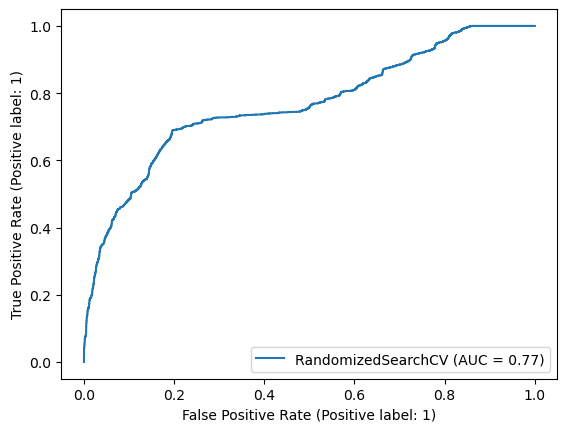

In [53]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_NB_gs, x_valid, y_valid);

In [54]:
# Confusion matrix
print(confusion_matrix(y_valid, y_preds))

[[1906351       0]
 [   2428       7]]


## Permutation Importance
Let's find the permutation importance for our `GaussianNB()` model...

In [55]:
# Fit an instance of GaussianNB
rs_NB_gs.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=20,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.5111917...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=42, verbose=1)

In [63]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(rs_NB_gs, x_valid, y_valid)
perm_dict = dict(zip(x.columns, list(imps.importances_mean)))
perm_dict

{'step': 0.0,
 'type': 1.0477863940927534e-07,
 'amount': 0.0,
 'oldbalanceOrg': 0.0,
 'newbalanceOrig': -5.238931970463767e-07,
 'oldbalanceDest': 0.0,
 'newbalanceDest': 0.0,
 'isFlaggedFraud': 6.286718364445498e-06}

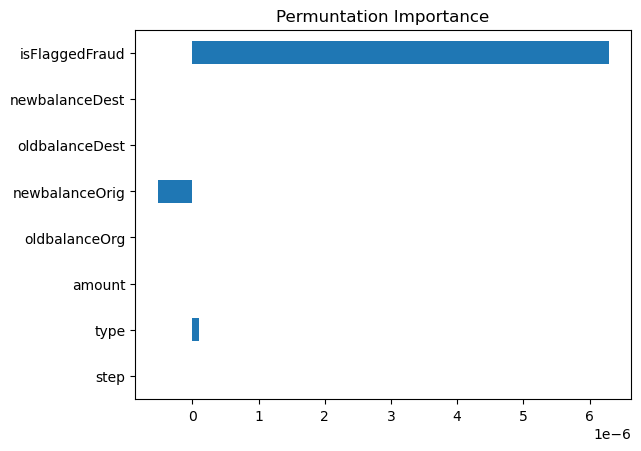

In [64]:
# Visualize feature importance
perm_df = pd.DataFrame(perm_dict, index = [0])
perm_df.T.plot.barh(title = "Permuntation Importance", legend = False);

It seems that the features didn't really help us much in training our model except `isFlaggedFraud` and `type`. We need to collect more data and track the transactions. 

Answering the remaining questions to my abillity and understaning...

Q. What are the key factors that predict fraudulent customer?

A. According to the `feature importance` as we can see, that only isFlaggedFraud and type has helped us in the predictions we made. But it is essential that we collect more information, such as we should start tracking location (ip addresses) from where the transactions are being made and where the transactions are being transferred,real time date and time. After every transaction, a messeage should be sent to the customers and if the amount is more than 200000 the transaction should be kept on hold as long as there is a personal verfication confirmation from the customer. If a particular method of Payment is used most for Fraud, why is it so? What are the loopholes which we are missing? We need to answer these questions with reseach, information and development.

Q. Do these factors make sense? If yes, How? If not, How not?

A. The Factors do makes sense. Even if all the factors are not helping in training the model, it helps us in analysing the data. For eg, if we make a program which analyzes all the transactions of a person, the time, the duration between 2 transactions... analyzes the pattern and if there is an unusual transaction, it sends an alert. 

Whereas, factors such as record of the beneficiary and the recepient is not that important for training models but it is good for maintaining records in the database. 

Q. What kind of prevention should be adopted while company update its infrastructure?

A. Company should be careful of Security Breaches, Data Leaks and Customter Information Safety.

Q. Assuming these actions have been implemented, how would you determine if they work?

A. We analyse the new set of transactions with some fabricated fraud transactions (with all kinds of fraud transactions... large amounts, small amounts, use vpn to change location, use firewall to protect our information) and then test our model on those transactions and see if our model can detect these transactions. If not we can determine what areas we need to work on.